# Loading Dependencies

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dowhy
import os
import feature_eng
from get_datasets import reduce_memory_usage
from tqdm import tqdm
import econml
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

MAIN_DIR = os.getcwd()

FEATURES = ["AccV", "AccML", "AccAP"]
TARGETS = ["StartHesitation", "Turn", "Walking"]

new_features = ['AccA', 'RelTime', 'AccML_f1', 'AccML_f2', 'AccAP_f1', 'AccAP_f2', 'AccV_f1', 'AccV_f2']
# new_features = ['AccA', 'AccML_f1', 'AccML_f2', 'AccAP_f1', 'AccAP_f2', 'AccV_f1', 'AccV_f2']
acc_features = ['AccV', 'AccML', 'AccAP']

FEATURES = acc_features + new_features


def add_features(query_datatype):
    for acc_feature in acc_features:
        query_datatype[acc_feature] /= 9.8
    query_datatype = feature_eng.generate_features(query_datatype, new_features, True,'train')
    return query_datatype


def read_data(
        dataset,
        datatype,
        targets,
        subject_ids=None):
    metadata = pd.read_csv(os.path.join(MAIN_DIR , (dataset + "_metadata.csv")))
    sub_metadata = pd.read_csv(os.path.join(MAIN_DIR , "Subjects.csv"))
    metadata = metadata.merge(sub_metadata, on='Subject')
    if subject_ids is not None:
        metadata = metadata.loc[metadata['Subject'].isin(subject_ids)]
        metadata = metadata
    DATA_ROOT = MAIN_DIR + '/'+datatype + "/" + dataset

    counter = 0
    df_res = pd.DataFrame()
    for root, dirs, files in os.walk(DATA_ROOT):
        for name in tqdm(files[:250]):
            if name[:-4] in metadata['Id'].values:
                counter += 1
                f = os.path.join(root, name)
                query_datatype = pd.read_csv(f)
                query_datatype = add_features(query_datatype)
                # TODO: change to zeros, but come up with values for time (it's fine if events are all zeros)
                query_datatype = pd.concat(
                    [pd.DataFrame(np.zeros((128, len(query_datatype.columns))), columns=query_datatype.columns),
                     query_datatype], ignore_index=True)
                query_datatype["file"] = name.replace(".csv", "")
                df_res = pd.concat([df_res, query_datatype])

    df_res = metadata.merge(df_res,
                            how='inner',
                            left_on='Id',
                            right_on='file')

    df_res = df_res.drop(["file"], axis=1)
    df_res['False_Class'] = (df_res[targets].sum(axis=1) == 0) * 1
    df_res = reduce_memory_usage(df_res)
    return df_res

# Loading the data

In [14]:
# TARGETS = ["StartHesitation", "Turn", "Walking"]  # define targets without the false class
# sess_df = pd.read_csv(os.path.join(MAIN_DIR, 'tdcsfog_metadata.csv'))
sub_df = pd.read_csv(os.path.join(MAIN_DIR, 'Subjects.csv'))
# unique_users = sess_df['Subject'].unique()
# train_users= unique_users
# data = read_data(
# dataset = "tdcsfog",
# datatype = "train",
# targets = TARGETS,
# subject_ids = train_users
#     )
# mapping = {'on': 1.0, 'off': 0.0}
# data['Medication'] = data['Medication'].map(mapping).astype(float)
# data = data.drop('Visit_y',axis=1).drop('Time', axis=1)
# averages = data[data['False_Class'] == 0].groupby('Id').mean()
# averages_fc = data[data['False_Class'] == 1].groupby('Id').mean().dropna()
# data = pd.concat((averages_fc, averages)).dropna()
# print(data.columns)
data = sub_df
data['Sex']  = data['Sex'].replace({'M':1,'F':0})
data = data.dropna()

# Define the causal model

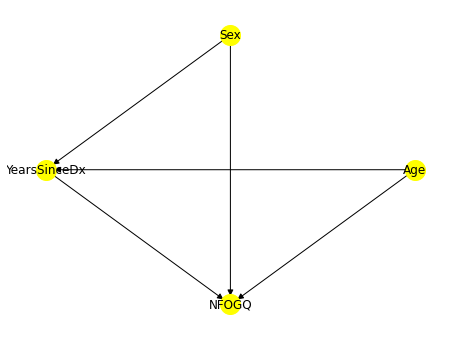

In [15]:
model = dowhy.CausalModel(
    data=data,
    treatment="YearsSinceDx",
    outcome="NFOGQ",
    common_causes=["Age",'Sex'],
)
model.view_model()
from IPython.display import Image, display
estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Define the statistic estimand and estimate the affect

In [16]:
DML_estimate = model.estimate_effect(estimand,
                                     method_name="backdoor.econml.dml.DML",
                                     method_params={"init_params": {
                                         'model_y': LinearRegression(),
                                         'model_t': LinearRegression(),
                                         'model_final': LinearRegression()
                                     },
                                         "fit_params": {}
                                     })
print(DML_estimate)
print('We refute the estimate using the placebo treatment refuter. This refuter substitutes the treatment by an independent random variable and checks whether our estimate now goes to zero (it should!).')
refutation = model.refute_estimate(estimand, DML_estimate, method_name="placebo_treatment_refuter",
                                   placebo_type="permute", num_simulations=70)
print(refutation)

print(f"Pretty strong ate. Taking meds reduces seizure intensity.\nLets compare to normal regression")


The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted,

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
───────────────(E[NFOGQ|Age,Sex])
d[YearsSinceDx]                  
Estimand assumption 1, Unconfoundedness: If U→{YearsSinceDx} and U→NFOGQ then P(NFOGQ|YearsSinceDx,Age,Sex,U) = P(NFOGQ|YearsSinceDx,Age,Sex)

## Realized estimand
b: NFOGQ~YearsSinceDx+Age+Sex | 
Target units: ate

## Estimate
Mean value: 0.06699605273278812
Effect estimates: [0.06699605 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605
 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605
 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605
 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605
 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605
 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605
 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605 0.06699605
 0.0669

The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted,

Refute: Use a Placebo Treatment
Estimated effect:0.06699605273278812
New effect:-0.002635368183576983
p value:0.48650584495608773

Pretty strong ate. Taking meds reduces seizure intensity.
Lets compare to normal regression


The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
The final model has a nonzero intercept for at least one outcome; it will be subtracted,

# Check normal regression to see if we imporoved

In [17]:
## Maybe check with normal regression scores to see if we did any good
import statsmodels.api as sm

variables = ["Age", "YearsSinceDx",'UPDRSIII_Off','UPDRSIII_On','Sex']
X = data[variables]
Y = data["NFOGQ"]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
# Get the effect size
effect_size = results.params

print(f"Effect Size: {effect_size}")

Effect Size: const           15.778676
Age             -0.044345
YearsSinceDx     0.057465
UPDRSIII_Off     0.096591
UPDRSIII_On      0.059992
Sex              0.284646
dtype: float64


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


## The causal affect is 0.135 and the statistic beta of the regression is only 0.05!

## We Will now try a counterfactual analysis. Can we get P(NFOGQ|do(age > 60),Years_since_diagnosis)?


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


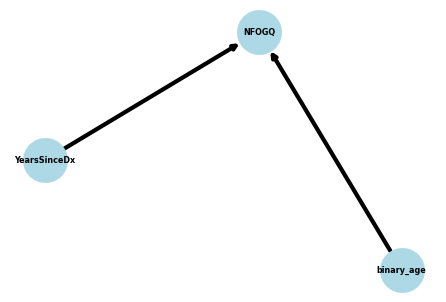

Fitting causal mechanism of node YearsSinceDx: 100%|██████████| 3/3 [00:00<00:00, 454.75it/s]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [18]:
import networkx as nx
import dowhy.gcm as gcm
data['binary_age'] = data['Age'] > 60
causal_model = gcm.InvertibleStructuralCausalModel(nx.DiGraph([('binary_age', 'NFOGQ'), ('YearsSinceDx', 'NFOGQ')]))
gcm.auto.assign_causal_mechanisms(causal_model, data)

gcm.util.plot(causal_model.graph)

gcm.fit(causal_model, data.iloc[:-10])
new_patients = data.iloc[-10:][data.iloc[-10:]['binary_age']==1.0]
picked_columns = ['binary_age','YearsSinceDx','NFOGQ']
new_patients = new_patients[picked_columns]
counterfactual_data2 = gcm.counterfactual_samples(causal_model,
                                                  {'binary_age': lambda x: 0.0},
                                                  observed_data=new_patients)


In [ ]:
import matplotlib.pyplot as plt

df_plot2 = pd.DataFrame()
df_plot2['NFOGQ'] = new_patients['NFOGQ']
df_plot2['Counterfactual NFOGQ (age > 60)'] = counterfactual_data2['NFOGQ'].to_numpy()

df_plot2.plot.bar(title="Counterfactual outputs")
plt.ylabel('NFOGQ')
# plt.xlabel(list(new_patients.index))
plt.legend()
plt.show()

## We will now try Causal Discovery

In [ ]:
import networkx as nx
import cdt
from cdt.causality.graph import CGNN, SAM
cdt.SETTINGS.NJOBS = 3
obj = SAM()
plt.figure(figsize=(15,15))
plt.title('Causal Graph Discovery using SAM')
# output = obj.predict(data)
nx.draw_networkx(output, font_size=15)
plt.show()

# obj = CGNN(nruns=12)
# plt.figure()
# plt.title('Causal Graph discovery using CGNN')
# output = obj.predict(data_for_discovery)
# nx.draw_networkx(output, font_size=8)
# plt.show()
